In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict

import skimage
import numpy as np
import pandas as pd
import scipy
import numpy_indexed as npi

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import cv2

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

import torchvision.models as models

In [4]:
import sys

sys.path.append('..')
import src.utils.dataset as ds
from src.utils.visualisation import *
from src.configs.config import *
from src.configs import config
from src.utils import learner as lrn
from src.utils import lr_finder as lrf
from src.utils import augmentations as augs
from src.utils import visualisation
from src.modules import densenet

%load_ext autoreload
%autoreload 2
# # import losses
# # import metrics


/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))


In [ ]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
labels.head(1)

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
folds = ds.get_folds(PARAMS['NB_FOLDS'], PARAMS['SEED'])
for key in appearance.keys():
    print(key)
    print(
        labels.loc[folds[0][0], key].sum() / len(labels.loc[folds[0][0]]), 
        labels.loc[folds[0][1], key].sum() / len(labels.loc[folds[0][1]]),
        '\n'
    )

Nucleoplasm
0.39672587034656454 0.398836050962093 

Nuclear membrane
0.02779599653697825 0.02752582184239501 

Nucleoli
0.0954167431854553 0.09589472028521995 

Nucleoli fibrillar center
0.033174174252957996 0.03350285744245792 

Nuclear speckles
0.049085709788283444 0.04860273685314319 

Nuclear bodies
0.05104021827531023 0.0512766738321187 

Endoplasmic reticulum
0.03376446205105334 0.03402715881088449 

Golgi apparatus
0.07703911640475379 0.07696744088502071 

Peroxisomes
0.0019151559671537633 0.001939915063178315 

Endosomes
0.0013773381955557887 0.0014680438315944004 

Lysosomes
0.0012068106094393577 0.001258323284223772 

Intermediate filaments
0.018967914578796864 0.018769988989671263 

Actin filaments
0.017131463651389144 0.017197084884391547 

Focal adhesion sites
0.011228585670435763 0.011272479421171289 

Microtubules
0.024700264973633812 0.024694594452891523 

Microtubule ends
0.0004066427053545662 0.00041944109474125726 

Cytokinetic bridge
0.009064197077419523 0.009070413

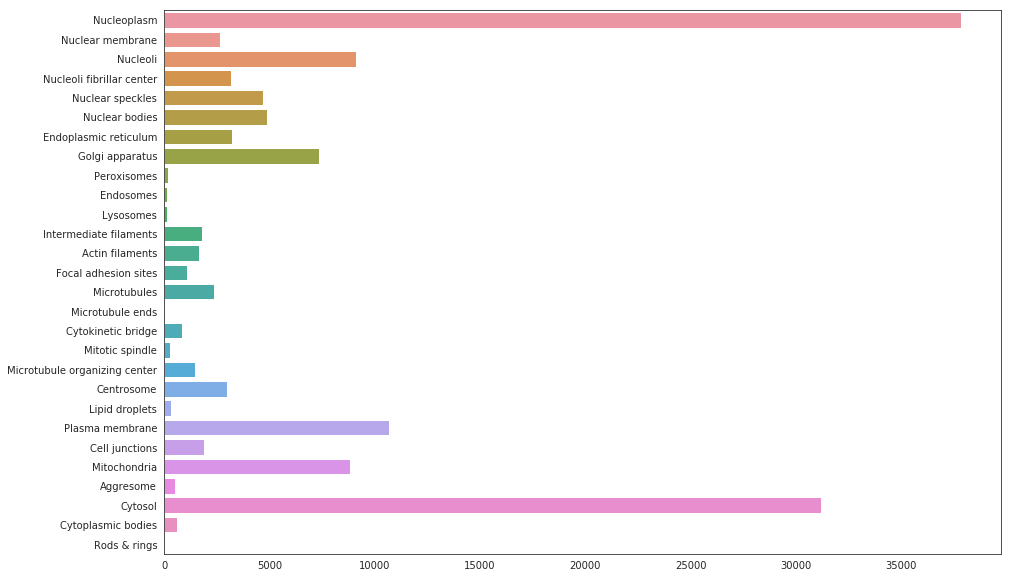

In [8]:
keys = list(config.appearance.keys())
values = np.array(list(config.appearance.values()))

plt.figure(figsize=(15, 10))
sns.barplot(y=keys, x=values);
plt.show()

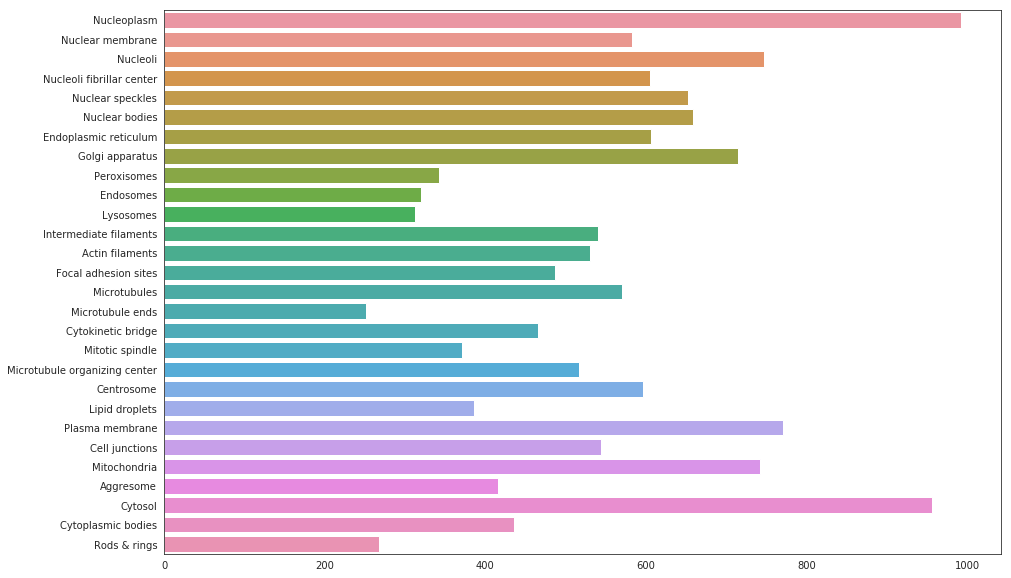

In [9]:
amounts = values * np.power(config.PARAMS['SUPPORT_CLASS_AMOUNT'] / values, config.PARAMS['SUPPORT_POWER'])
amounts = amounts.astype(np.int)

plt.figure(figsize=(15, 10))
sns.barplot(y=keys, x=amounts);
plt.show()

In [10]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [11]:
import os


def create_dir(path):
    try:
        os.mkdir(path)
        print('Directory created: {}'.format(path))
    except:
        print('Directory exists: {}'.format(path))


def init_history(path):
        if os.path.isfile(path):
            return pickle.load(open(path, 'rb'))
        else:
            return defaultdict(list)


def format_predictions(results):
    predictions = np.concatenate([r['prediction'] for r in results])
#     predictions = torch.sigmoid(torch.tensor(predictions))
    labels = np.concatenate([r['label'] for r in results])
    loss = np.concatenate([r['loss'].reshape(1) for r in results])
    f1_score = measure_f1(predictions, labels)
    return {
        'predictions': predictions,
        'labels': labels,
        'loss': loss,
        'f1_score': f1_score,
    }

def prepare_data(datagen, nb_samples=PARAMS['NB_INFERS']):
    if isinstance(nb_samples, int):
        nb_samples = range(nb_samples)
    data = [datagen.dataset[i] for i in nb_samples]
    data = datagen.collate_fn(data)
    return data


def measure_f1(predictions, labels, threshs=.5):
    if isinstance(threshs, float):
        threshs = [threshs] * labels.shape[-1]
    return [
        sklearn.metrics.f1_score(labels[:, i], predictions[:, i] > threshs[i]) 
        for i, el in enumerate(label_names_list)
    ]


def format_history(history):
    return {
        key: [np.mean([el[key]]) for el in history] 
        for key in PARAMS['PLOT_KEYS']
    }


def plot_losses(formated_train, formated_valid):
    _, axes = plt.subplots(ncols=len(PARAMS['PLOT_KEYS']), figsize=(10 * len(PARAMS['PLOT_KEYS']), 6))

    for i, key in enumerate(PARAMS['PLOT_KEYS']):
        axes[i].plot(formated_valid[key], label='{} valid'.format(key), alpha=0.7, color='C{}'.format(i * 2))
        axes[i].plot(formated_train[key], label='{} trian'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

        axes[i].set_title(key)
        axes[i].legend()
        axes[i].grid()

    plt.show()

In [12]:
class Orchestrate:
    def __init__(self, learner, checkpoints_pth,
                 lr_scheduler=None,
                 fold=0, hard_negative_miner=None,
                 verbose=True, traced_key='loss', augmentations=None):
        self.learner = learner
        self.hard_negative_miner = hard_negative_miner
        self.verbose = verbose
        self.lr_scheduler = lr_scheduler
        self.traced_key = traced_key

        create_dir(checkpoints_pth)
        self.path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, '{}'))
        self.history = init_history(self.path.format('loss'))
        self.last_epoch = len(self.history['train_losses'])

        folds = ds.get_folds(PARAMS['NB_FOLDS'], PARAMS['SEED'])
        train_dataset, valid_dataset = ds.get_datasets(folds, fold, augmentations=augmentations)
        train_datagen, valid_datagen = ds.get_datagens(train_dataset, valid_dataset)
        self.train_datagen, self.valid_datagen = train_datagen, valid_datagen

    def __call__(self, nb_epochs=PARAMS['NB_EPOCHS']):
        for epoch_i in range(self.last_epoch, nb_epochs):
            if hasattr(self.lr_scheduler, 'step'):
                self.lr_scheduler.step()
            self.learner.freeze_encoder(unfreeze=(epoch_i >= PARAMS['NB_FREEZED_EPOCHS']))

            self.iteration(epoch_i)
            self.checkpoint(epoch_i, nb_epochs)

    def iteration(self, epoch_i):
        meters = self.learner.train_on_epoch(
            self.train_datagen, 
            hard_negative_miner=self.hard_negative_miner,
            lr_scheduler=self.lr_scheduler
        )
        meters = format_predictions(meters)
        self.history['train_losses'].append(meters)

        meters = self.learner.validate(self.valid_datagen)
        meters = format_predictions(meters)
        self.history['valid_losses'].append(meters)

        clear_output(wait=True)

    def checkpoint(self, epoch_i, nb_epochs):
        if self.verbose:
            plt.figure(figsize=(15,10))
            sns.barplot(y=label_names_list, x=self.history['valid_losses'][-1]['f1_score']);
            plt.show()
            
            formated_train = format_history(self.history['train_losses'])
            formated_valid = format_history(self.history['valid_losses'])
            plot_losses(formated_train, formated_valid)
            data = prepare_data(self.valid_datagen, PARAMS['NB_INFERS'])
            self.learner.infer_on_data(data)

        trace = formated_valid[self.traced_key]
        if trace[-1] >= max(trace):
            state_dict = self.learner.save(self.path.format('best'))
        if epoch_i == (nb_epochs - 1):
            state_dict = self.learner.save(self.path.format(epoch_i))

        pickle.dump(self.history, open(self.path.format('loss'), 'wb'))


In [13]:
loss = FocalLoss(gamma=2)
augmentations = augs.Augmentation(side=PARAMS['SIDE'], simplex_noise=PARAMS['SIMPLEX_NOISE'])

# Inference

In [14]:
test_df = pd.read_csv(os.path.join(config.PATHS['CSV'], 'sample_submission.csv'))
for name in config.label_names_list + ['Predicted', 'Target']:
    test_df[name] = 0

In [15]:
class FakeFC(torch.nn.Linear):
    def forward(self, input):
        if self.training: return F.linear(input, self.weight, self.bias)
        else: return input



In [16]:
def prepare_learner(fold, checkpoint, fake_fc=False):
#     model = densenet121(pretrained=True)
#     model = lrn.set_io_dims_densnet(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
    model = models.resnet50(pretrained=True)
    model = lrn.set_io_dims(model, dropout=.5)

    if fake_fc:
        fc = model.fc
        fake_fc = FakeFC(fc.in_features, fc.out_features, bias=fc.bias is not None)
        fake_fc.load_state_dict(fc.state_dict())
        model.fc = fake_fc

    model = lrn.get_model(model, checkpoint=checkpoint, devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()

    learner = lrn.Learner(model=model, opt=None, loss=None)
    return learner

def prepare_data(fold):
    folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
    _, valid_dataset = ds.get_datasets(folds, fold)

    test_dataset = ds.ProteinDataset(
        test_df,
        config.PATHS['TEST'], 
        config.label_names_list, 
        augmentations=None
    )
    return valid_dataset, test_dataset


In [17]:
def split_image(image, mask):
    colours = np.unique(mask[mask != 0])
    if len(colours) > 1:
        kfold = sklearn.model_selection.KFold(n_splits=min(10, len(colours)), shuffle=True, random_state=42)
        idxs = [colours[cidx] for _, cidx in list(kfold.split(colours))]
        masks = np.array([np.isin(mask, idx) for idx in idxs])
    else:
        idxs = [1]
        masks = np.zeros(shape=(1, ) + mask.shape, dtype=np.bool_)

    images = list()
    for mask in masks:
        im = image.data.numpy().copy()
        im[:, mask] = np.expand_dims(-ds.MEAN / ds.STD, -1)
        images.append(im)
    return np.array(images), idxs

In [18]:
def infer(model, idx, data, predicts, labels=None, fake_fc=False, use_instances=False):
    with torch.no_grad():
        image, mask = data['image'], data['mask']
        if use_instances:
            image, idxs = split_image(image, mask)

        if config.PARAMS['SIDE'] is not None:
            image = augs.get_crops(image, config.PARAMS['SIDE'])
        image = augs._rotate_mirror_do(image)

        image = torch.tensor(image)
        image = torch.autograd.Variable(image).cuda()
        predict = model(image)

        if not fake_fc:
            predict = torch.sigmoid(predict)

#         print(predict.shape)
        predict = predict.reshape(predict.shape[0] // 8, 8, -1)
        predicts[idx, :predict.shape[0]] = predict.mean(1).data.cpu().numpy()

        image = image.data.cpu()
        if labels is not None:
            labels[idx] = data['label']

        return idxs

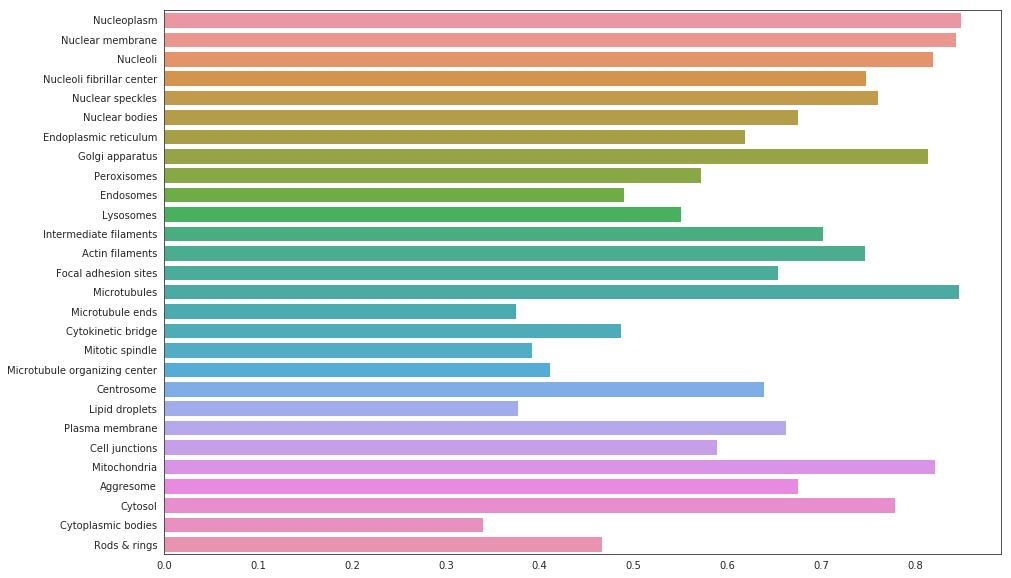

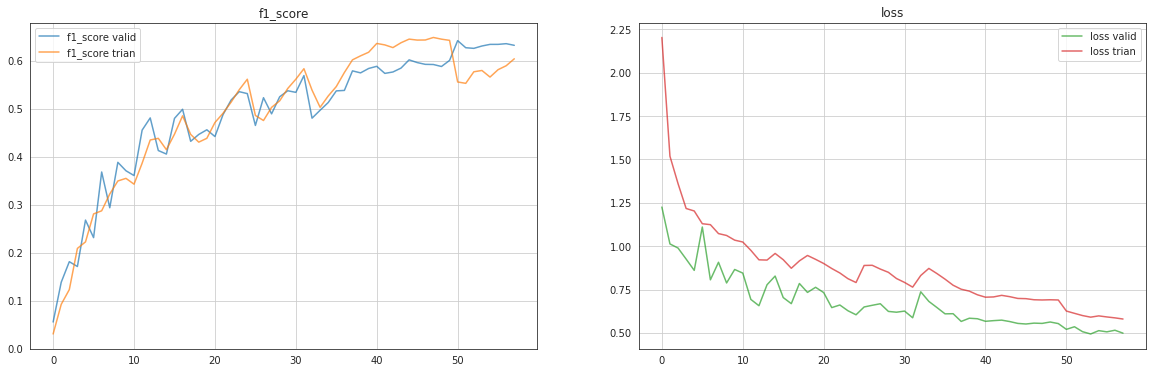

In [19]:
history = pickle.load(open('../data/models/resnet50_pure/fold_0_checkpoint.epoch_loss', 'rb'))
plt.figure(figsize=(15,10))
sns.barplot(y=label_names_list, x=history['valid_losses'][-1]['f1_score']);
plt.show()

formated_train = format_history(history['train_losses'])
formated_valid = format_history(history['valid_losses'])
plot_losses(formated_train, formated_valid)

In [20]:
def orchestrate_inference(fold, checkpoints_pth, epoch, fake_fc=False, use_instances=False):
    template_path = 'fold_{}_checkpoint.epoch_{}'
    path = os.path.join(checkpoints_pth, template_path)
    dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
    
    history = pickle.load(open(path.format(fold, 'loss'), 'rb'))
    plt.figure(figsize=(15,10))
    sns.barplot(
        y=label_names_list, 
        x=history['valid_losses'][epoch if isinstance(epoch, int) else -1]['f1_score']
    );
    plt.show()

    formated_train = format_history(history['train_losses'])
    formated_valid = format_history(history['valid_losses'])
    plot_losses(formated_train, formated_valid)
    
    learner = prepare_learner(fold, path.format(fold, epoch), fake_fc=fake_fc)
    valid_dataset, test_dataset = prepare_data(fold)
    
    predicts = -np.ones(shape=(
        len(test_dataset), 
        10,
        learner.model.module.fc.in_features if fake_fc else len(config.label_names_list)
    ))
    test_colours = list()
    for idx in tqdm(range(len(test_dataset))):
        test_colours.append(
            infer(learner.model, idx, test_dataset[idx], predicts, labels=None, fake_fc=fake_fc, use_instances=use_instances)
        )

    pickle.dump(test_colours, open(dump_path.format('test_instances_colours.pkl', fold), 'wb'))
    np.save(dump_path.format('test_predicts_instances', fold), predicts)
    test_dataset.keys.to_csv(dump_path.format('test_keys', fold))


    valid_predicts = np.zeros(shape=(
        len(valid_dataset), 
        10,
        learner.model.module.fc.in_features if fake_fc else len(config.label_names_list)
    ))
    valid_labels = np.zeros(shape=(len(valid_dataset), len(config.label_names_list)))
    valid_colours = list()
    for idx in tqdm(range(len(valid_dataset))):
        valid_colours.append(
            infer(learner.model, idx, valid_dataset[idx], valid_predicts, labels=valid_labels, fake_fc=fake_fc, use_instances=use_instances)
        )

    pickle.dump(valid_colours, open(dump_path.format('valid_instances_colours.pkl', fold), 'wb'))
    np.save(dump_path.format('valid_predicts_instances', fold), valid_predicts)
    np.save(dump_path.format('valid_labels', fold), valid_labels)
    valid_dataset.keys.to_csv(dump_path.format('valid_keys', fold))


In [21]:
epoch = 'best'
checkpoints_pth = '../data/models/resnet50_pure/'

In [22]:
config.PARAMS['SIDE'] = None

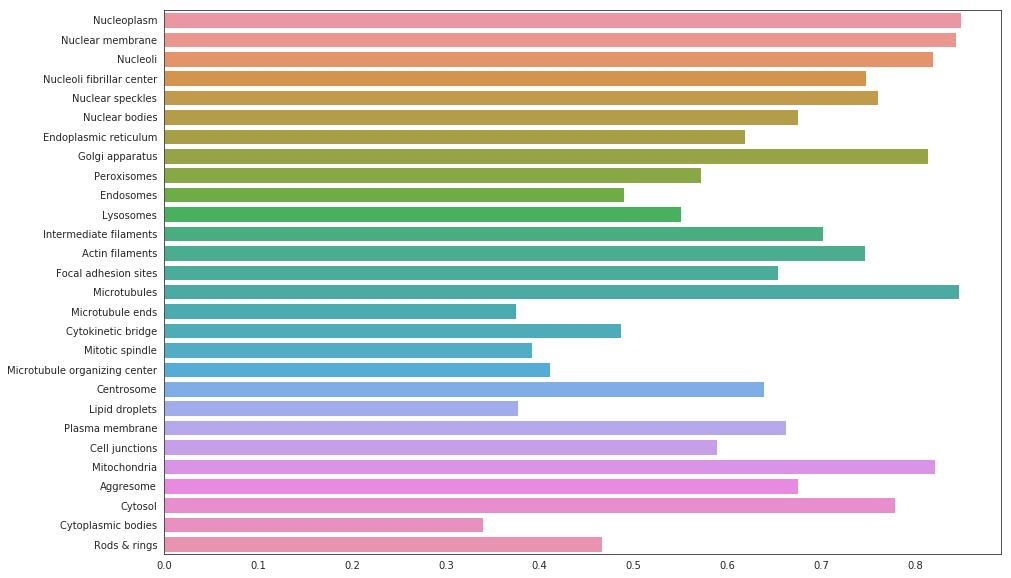

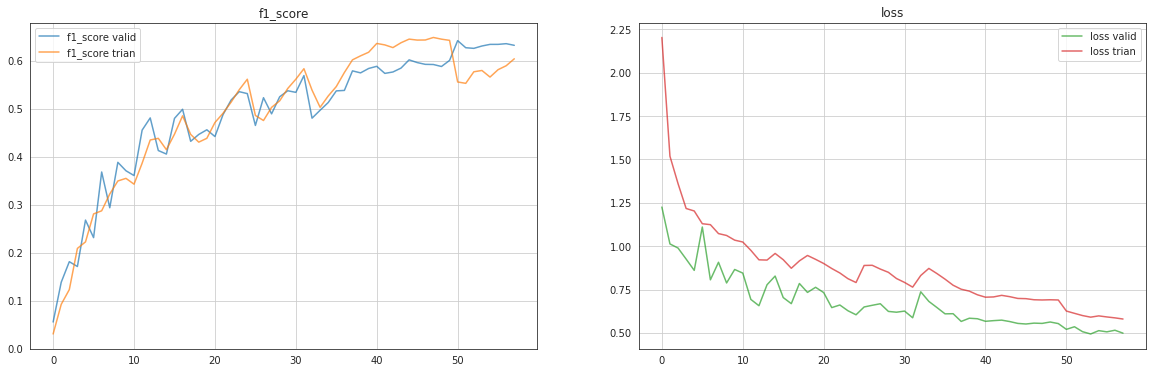

Overlapped keys: 320


 47%|████▋     | 8895/19073 [2:03:44<2:21:34,  1.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 19073/19073 [4:22:44<00:00,  1.21it/s]


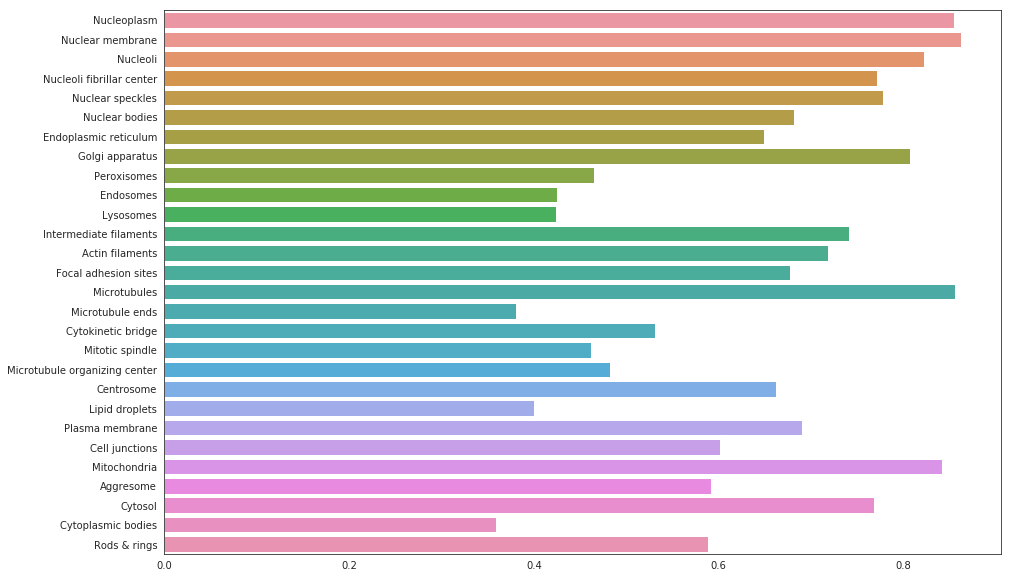

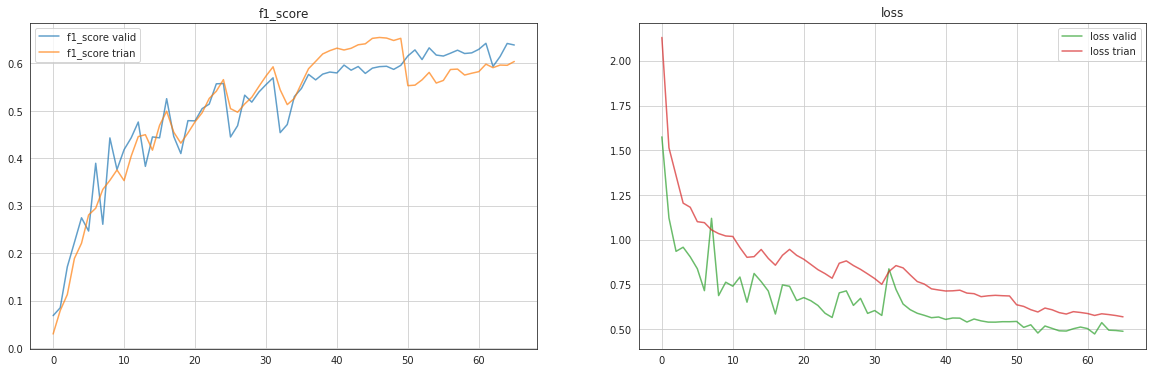

Overlapped keys: 320


100%|██████████| 19063/19063 [4:19:15<00:00,  1.23it/s]


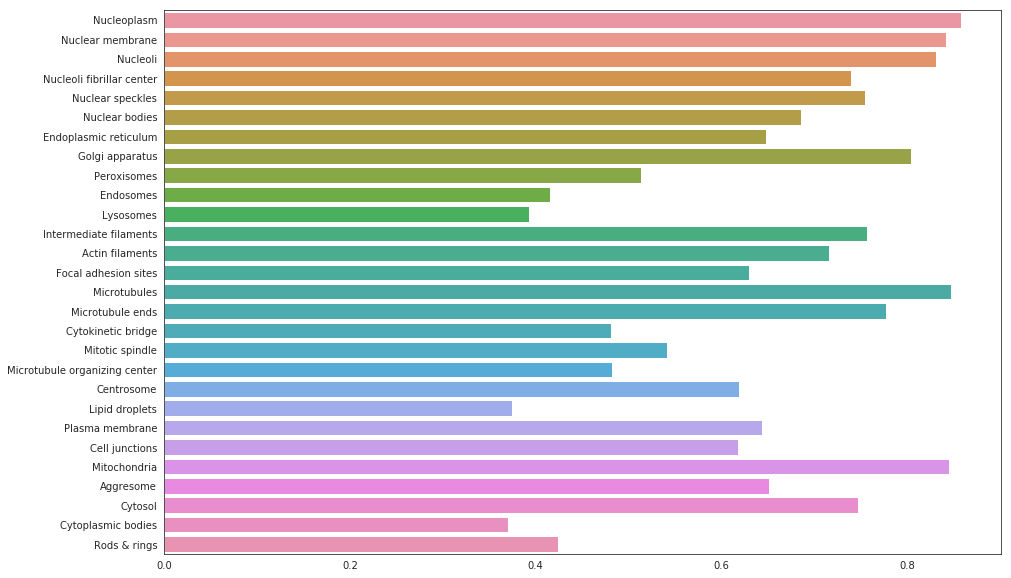

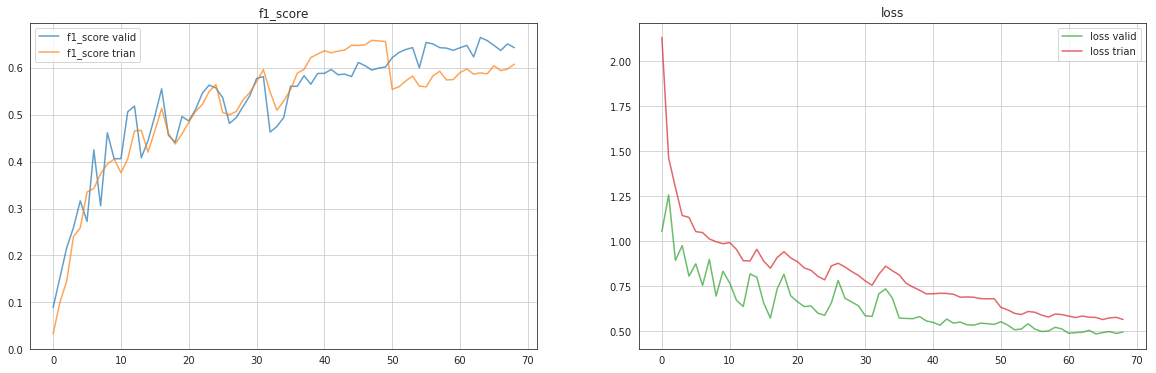

Overlapped keys: 320


  8%|▊         | 1477/19061 [39:21<7:48:32,  1.60s/it]

In [ ]:
for fold in range(config.PARAMS['NB_FOLDS']):
    orchestrate_inference(fold, checkpoints_pth, epoch, fake_fc=False, use_instances=True)

In [89]:
dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
template_path = 'fold_{}_checkpoint.epoch_{}'
path = os.path.join(checkpoints_pth, template_path)


valid_predicts = list()
valid_labels = list()
for fold in range(config.PARAMS['NB_FOLDS']):
    valid_predicts.append(np.load(dump_path.format('valid_predicts_old', fold) + '.npy'))
    valid_labels.append(np.load(dump_path.format('valid_labels', fold) + '.npy'))
valid_predicts = np.concatenate(valid_predicts)
valid_labels = np.concatenate(valid_labels)


predicts = list()
for fold in range(config.PARAMS['NB_FOLDS']):
    predicts.append(np.load(dump_path.format('test_predicts_old', fold) + '.npy'))
predicts = np.stack(predicts)


In [90]:
def get_threshold(roc_curve):
    vec = np.ones(shape=(2, ))
    vec /= np.linalg.norm(vec, ord=2)
    pts = vec.reshape(2, 1) * np.dot(vec, roc_curve[:2])
    distances = np.linalg.norm(roc_curve[:2] - pts, ord=2, axis=0)
    idx = np.argmax(distances)
    return roc_curve[-1, idx], idx

In [91]:
valid_predicts.shape

(95307, 28)

In [92]:
labels_ = valid_labels
preds_ = valid_predicts#.max(1)

# labels_ = history['valid_losses'][epoch]['labels'] # np.concatenate([stamp['labels'] for stamp in history['valid_losses']])
# preds_ = history['valid_losses'][epoch]['predictions'] # np.concatenate([stamp['predictions'] for stamp in history['valid_losses']])

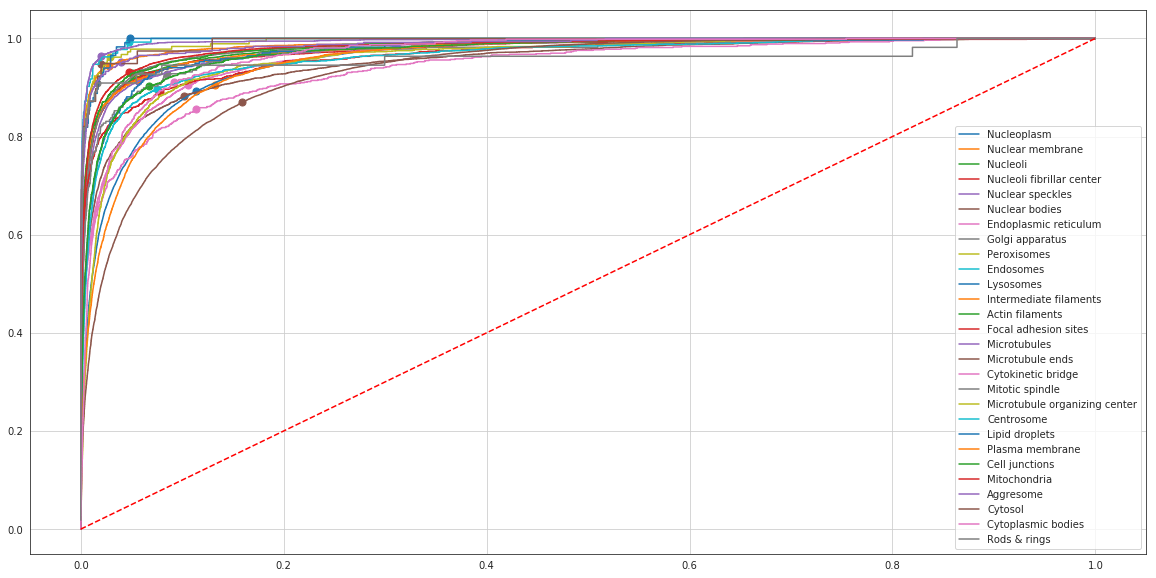

In [93]:
threshs = dict()
plt.figure(figsize=(20, 10))
for i in range(labels_.shape[-1]):
    roc_curve = sklearn.metrics.roc_curve(labels_[:, i], preds_[:, i])
    roc_curve = np.array(roc_curve)
    threshs[i], idx = get_threshold(roc_curve)
    plt.plot(roc_curve[0], roc_curve[1], label=label_names[i])
    plt.scatter(roc_curve[0, idx], roc_curve[1, idx], marker='o', s=50)

plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--')
plt.legend()
plt.grid()
plt.show()

threshs = np.array([threshs[i] for i, el in enumerate(label_names_list)])

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


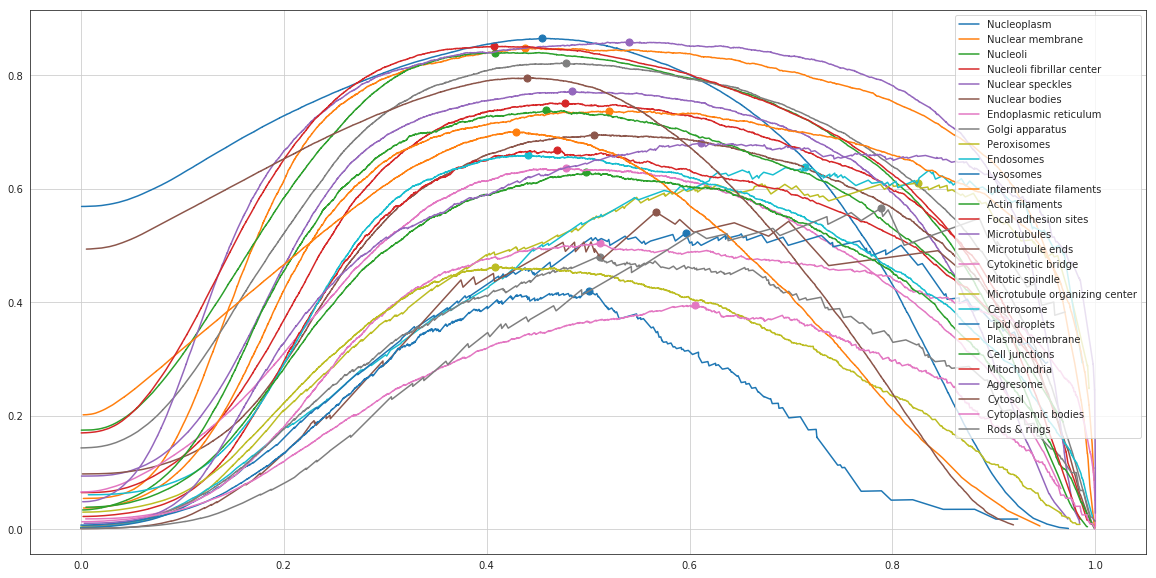

In [94]:
threshs = dict()
plt.figure(figsize=(20, 10))
for i in range(labels_.shape[-1]):
    roc_curve = sklearn.metrics.roc_curve(labels_[:, i], preds_[:, i])
    roc_curve = np.array(roc_curve)
    f1_scores = [sklearn.metrics.f1_score(labels_[:, i], preds_[:, i] >= t) for t in roc_curve[-1]]
    idx = np.argmax(f1_scores)
    threshs[i] = roc_curve[-1][idx]
    plt.plot(roc_curve[-1][1:-1], f1_scores[1:-1], label=label_names[i])
    plt.scatter(roc_curve[-1, idx], f1_scores[idx], marker='o', s=50)

plt.legend()
plt.grid()
plt.show()

threshs = np.array([threshs[i] for i, el in enumerate(label_names_list)])

In [107]:
folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
# _, valid_dataset = ds.get_datasets(folds, fold)

test_dataset = ds.ProteinDataset(
    test_df, 
    config.PATHS['TEST'], 
    config.label_names_list, 
    augmentations=None
)

In [96]:
history = pickle.load(open(path.format(fold, 'loss'), 'rb'))

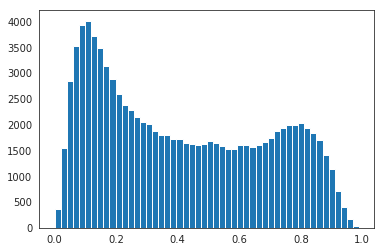

In [97]:
plt.hist(preds_[:, 0], 50);

In [98]:
np.mean(measure_f1(preds_, labels_, threshs=.5))

0.6474630692537805

In [99]:
np.mean(measure_f1(preds_, labels_, threshs=threshs))

0.6653468810762835

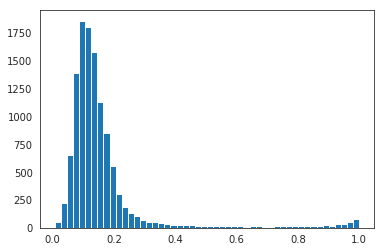

In [149]:
plt.hist(predictions[:, 1], 50);

In [301]:
selected = (predictions > np.maximum(.7, threshs)).sum(1)
idxs = np.where(selected)
keys = pd.read_csv(dump_path.format('test_keys', fold), header=None)

ids = pd.DataFrame(keys[1].values[idxs], columns=['Id'])
values = pd.DataFrame(predictions[idxs] > np.maximum(.65, threshs), columns=config.label_names_list)

labels = np.where(values[config.label_names_list].values)
labels = npi.group_by(labels[0]).split(labels[1])
labels = pd.DataFrame(pd.Series([' '.join([str(l) for l in sample]) for sample in labels]), columns=['Target'])

df = pd.concat([ids, labels, values], axis=1)
df[config.label_names_list] = df[config.label_names_list].astype(np.int)

df.to_csv(os.path.join(config.PATHS['CSV'], 'pseudolabels.csv'), index=False)

In [302]:
df.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001765de-bacd-11e8-b2b8-ac1f6b6435d0,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


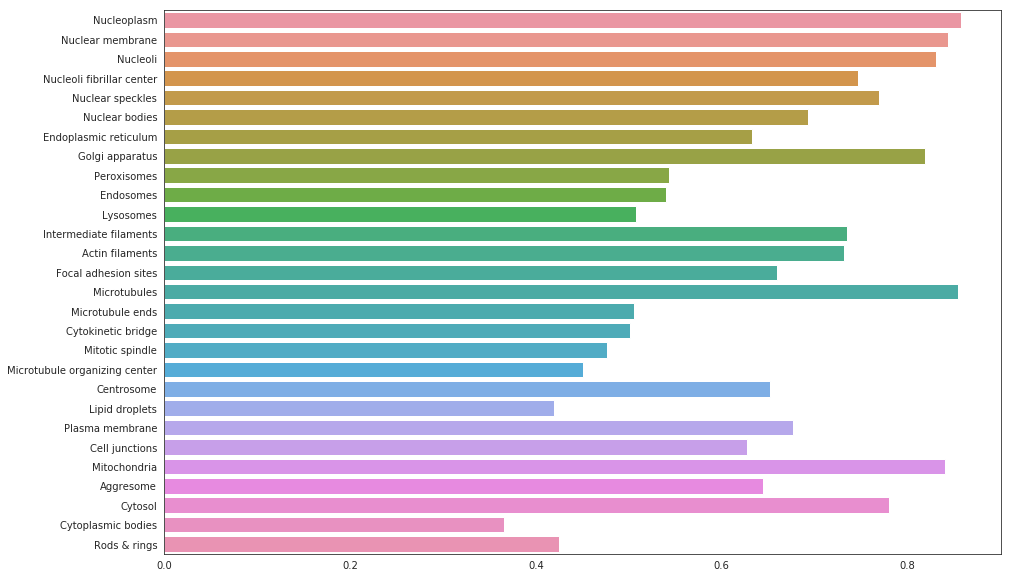

In [114]:
plt.figure(figsize=(15,10))
sns.barplot(y=config.label_names_list, x=measure_f1(preds_, labels_));
plt.show()

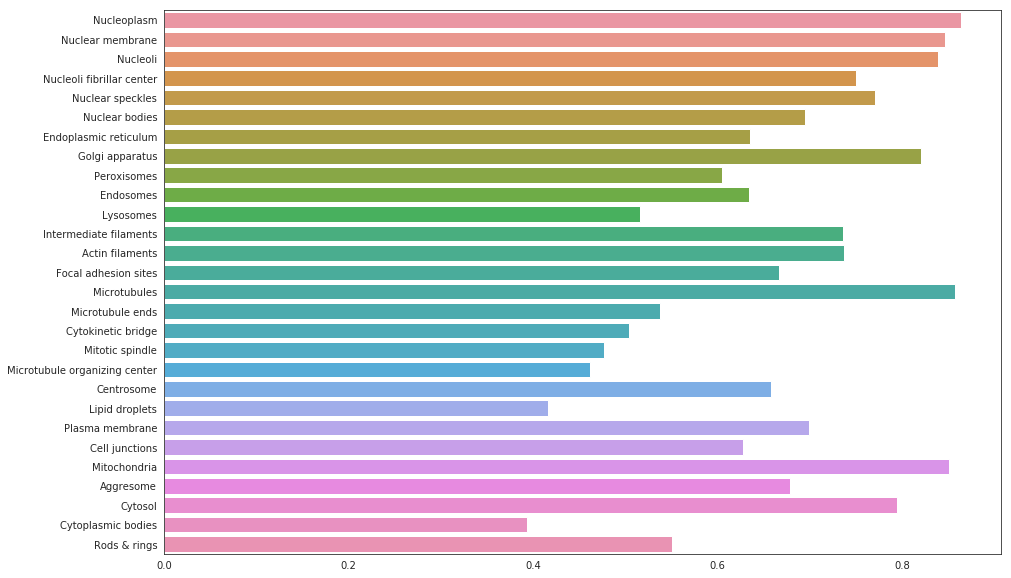

In [115]:
plt.figure(figsize=(15,10))
sns.barplot(y=config.label_names_list, x=measure_f1(preds_, labels_, threshs=threshs));
plt.show()

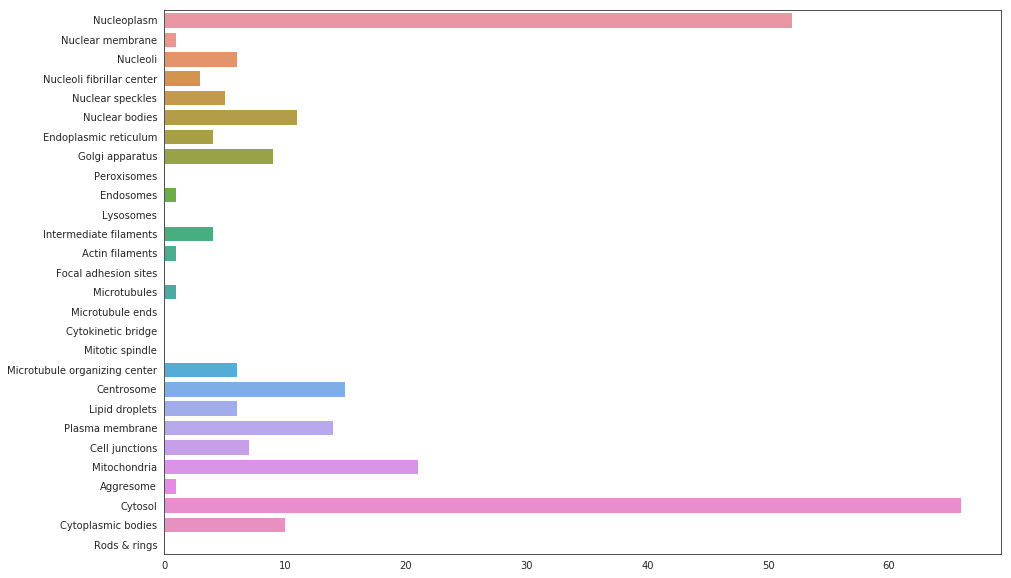

In [170]:
threshold = threshs # .5
predictions = predicts.max(0) # format_predictions(results)['predictions']


selected = predictions > threshold
idxs_mask = ~np.any(selected, axis=1)
best_outs = np.argmax(predictions[idxs_mask] - threshs, axis=1)
selected[idxs_mask, best_outs] = True
counts = np.zeros(shape=(len(config.label_names_list, )))
counts[:max(best_outs) + 1] = np.bincount(best_outs)

plt.figure(figsize=(15, 10))
sns.barplot(y=config.label_names_list, x=counts);
plt.show()

idxs = np.array(np.where(selected))
groups = npi.group_by(idxs[0]).split(idxs[1])

In [125]:
for idx, el in tqdm(zip(np.unique(idxs[0]), groups)):
    # test_datagen.dataset.labels.loc[idx, [label_names[e] for e in el]] = predictions[idx, el]
    test_dataset.labels.loc[idx, 'Predicted'] = ' '.join(['%d' % e for e in el])

11702it [00:12, 922.36it/s]


In [126]:
test_dataset.labels['Id'] = test_dataset.labels.index
df = test_dataset.labels[['Id', 'Predicted']]
df.to_csv('simple.csv', index=False)

In [106]:
df[df.Predicted.isna()].shape

(0, 2)

(6808, 29)

In [27]:
test_dataset.labels.index

RangeIndex(start=0, stop=11702, step=1)

In [ ]:
pd.read_csv(pseudo_csv)

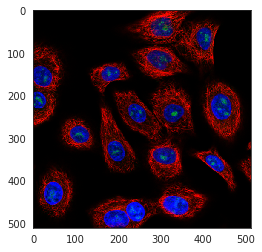

In [53]:
plt.imshow(cv2.imread('../data/test_shrinked/00008af0-bad0-11e8-b2b8-ac1f6b6435d0_blue_red_green.png'))